In [1]:
from jax import vmap, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import time

## Approximation on a Square

$\Omega = [0, 3 \pi]^2$. 

In [3]:
key = random.key(8765451678)

def kernel(gamma):
    def rbf(x, y):
        return jnp.exp(-gamma*jnp.sum((x-y)**2))
    return rbf

def g(x, y):
        return jnp.arctan((x - 2*y)/4)**2*jnp.sin((y + x)/2)

In [21]:
k = kernel(gamma=0.06)
vec_k = vmap(vmap(k, in_axes=(None ,0)), in_axes=(0, None))

n, n_test, m = 5000, 300, 25
lam = 0.1

X = random.uniform(key, (n, 2), minval=0, maxval=3*jnp.pi)
y = g(X[:, 0], X[:, 1]) + 0.2*random.normal(key, n)


idxs = random.permutation(key, n)[:m]
K = vec_k(X, X)
K_SS = K[:, idxs][idxs, :]
K_SX = K[idxs, :]

# To visualize function
x = jnp.linspace(0, 3*jnp.pi, n_test)
X_, Y_ = jnp.meshgrid(x, x)
g_true = g(X_,Y_)

X_test = jnp.concatenate((X_.reshape(-1, 1), Y_.reshape(-1, 1)), axis=1)

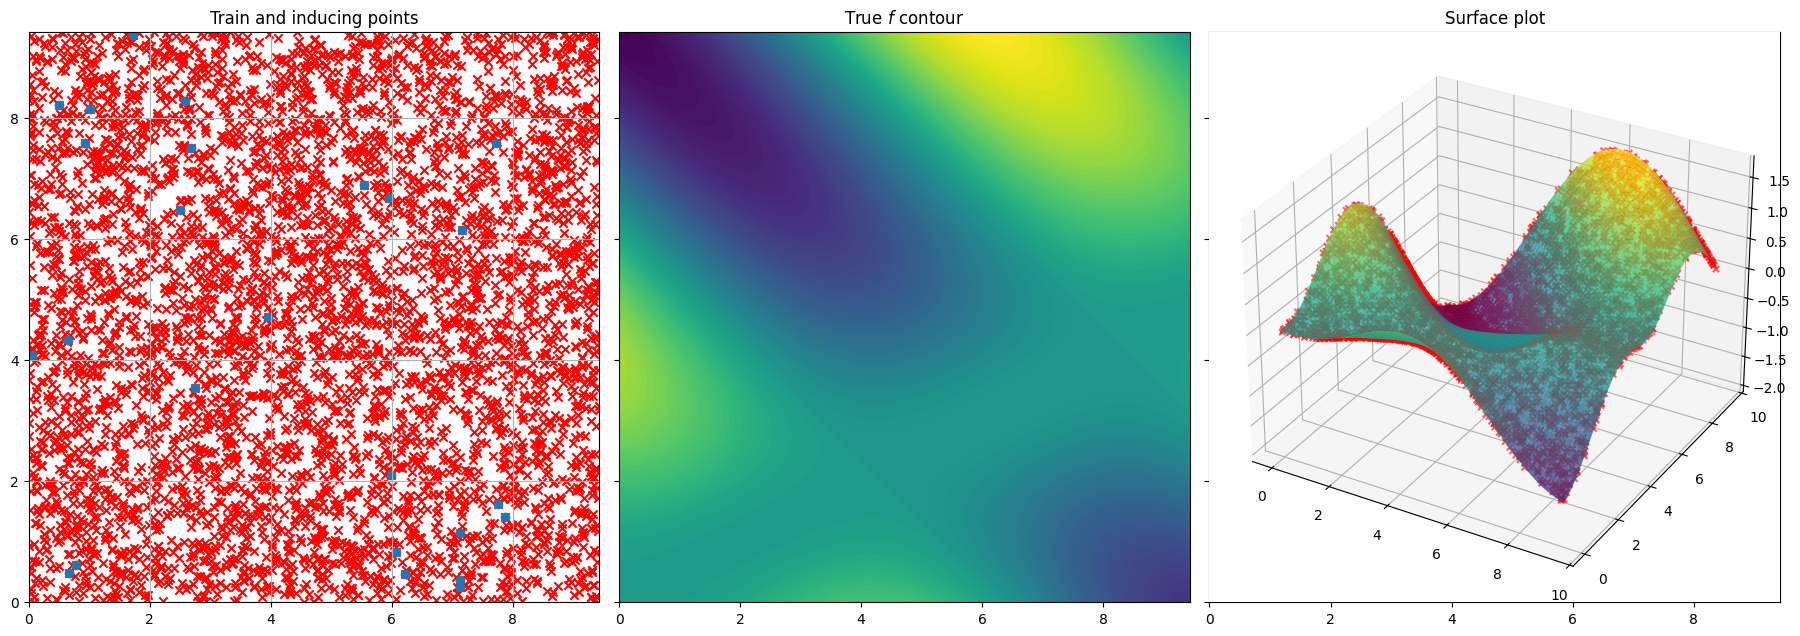

In [22]:
fig, axs  = plt.subplots(1, 3, figsize=(18, 9), sharey=True)
axs[0].grid()
axs[0].set_title("Train and inducing points")
axs[1].set_title("True $f$ contour")
axs[2].set_title("Surface plot")
axs[0].set_aspect('equal', 'box')
axs[1].set_aspect('equal', 'box')
axs[2].set_aspect('equal', 'box')
axs[0].set_xlim([x.min(), x.max()])
axs[0].set_ylim([x.min(), x.max()])
axs[1].set_xlim([x.min(), x.max()])
axs[1].set_ylim([x.min(), x.max()])
axs[2].set_xlim([x.min(), x.max()])
axs[2].set_ylim([x.min(), x.max()])

axs[0].scatter(X[:, 0], X[:, 1], label = "Training points", color='red', marker='x')
axs[0].scatter(X[idxs, 0], X[idxs, 1], label = "Inducing points")
axs[1].contourf(X_, Y_, g_true, levels=100)
axs[2] = fig.add_subplot(133, projection='3d')
axs[2].plot_surface(X_, Y_, g_true, cmap='viridis', alpha=0.8)
axs[2].scatter(X[:, 0], X[:, 1], g(X[:, 0], X[:, 1]), marker='x', color='r', alpha=0.6)
fig.tight_layout()

In [23]:
start = time.time()
# --------------------------------
alpha = jnp.linalg.solve(K + lam * jnp.eye(K.shape[0]), y)
g_predict = vec_k(X_test, X) @ alpha
# --------------------------------
end = time.time()

print(f"FULL KRR DONE IN {end - start} seconds")
print(f"Full KRR Error: {jnp.linalg.norm(g_true.flatten() - g_predict)/n_test}")

FULL KRR DONE IN 1.749098300933838 seconds
Full KRR Error: 0.0275378730148077


In [24]:
idxs = random.permutation(key, n)[:m]
K_mm = K[:, idxs][idxs, :]
K_nm = K[:, idxs]

# NOW NYSTROM
#-----------------------------
start = time.time()
alpha = jnp.linalg.solve(K_nm.T @ K_nm + lam * n_test * K_mm + 1e-6*jnp.eye(m),  K_nm.T @ y)
g_nystrom_predict = vec_k(X_test, X[idxs, :]) @ alpha
end = time.time()

#---------------------------------
print(f"NYSTROM DONE IN {end - start} seconds")
print(f"Nystrom Error: {jnp.linalg.norm(g_true.flatten() - g_nystrom_predict)/n_test}")

NYSTROM DONE IN 6.823897838592529 seconds
Nystrom Error: 0.19164443016052246


In [25]:
# STRICT SUBSET OF DATA
# ----------------------------
start = time.time()
alpha = jnp.linalg.solve(K_mm + lam * np.eye(m), y[idxs])
g_subset_predict = vec_k(X_test, X[idxs]) @ alpha
end = time.time()

print(f"STRICT SUBSET DONE IN {end  - start} seconds")
print(f"SoD Error: {jnp.linalg.norm(g_true.flatten() - g_subset_predict)/n_test}")

STRICT SUBSET DONE IN 0.18197250366210938 seconds
SoD Error: 0.3591630160808563


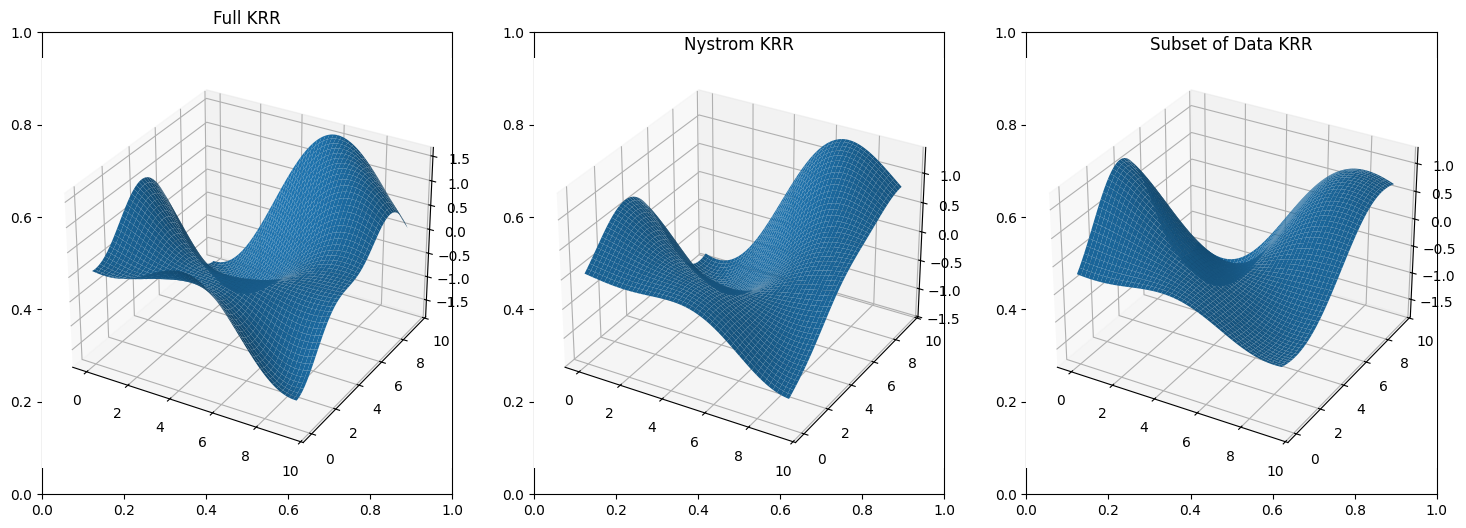

In [26]:
fig2, ax2 = plt.subplots(1, 3, figsize=(18, 6))
X_plot1, X_plot2 = X_test[:, 0], X_test[: ,1]

ax2[0].set_title("Full KRR")
ax2[0] = fig2.add_subplot(131, projection='3d')
ax2[0].plot_surface(X_plot1.reshape(n_test, n_test), X_plot2.reshape(n_test, n_test), g_predict.reshape(n_test, n_test))

ax2[1] = fig2.add_subplot(132, projection='3d')
ax2[1].set_title("Nystrom KRR")
ax2[1].plot_surface(X_plot1.reshape(n_test, n_test), X_plot2.reshape(n_test, n_test), g_nystrom_predict.reshape(n_test, n_test))

ax2[2] = fig2.add_subplot(133, projection='3d')
ax2[2].set_title("Subset of Data KRR")
ax2[2].plot_surface(X_plot1.reshape(n_test, n_test), X_plot2.reshape(n_test, n_test), g_subset_predict.reshape(n_test, n_test))